In [1]:
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt# display plots in this notebook
%matplotlib inline

plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

import sys, caffe, os
caffe_root = '/home/bit/temp2/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

caffe.set_mode_gpu()

work_root    = caffe_root + 'examples/shipHead8/'
model_def     = work_root + 'deploy.prototxt'
model_weights = work_root + 'shiphead8_iter_60000.caffemodel'

net = caffe.Net(model_def, model_weights, caffe.TEST)

mu = np.array([1.0, 1.0, 1.0])
#print 'mean-subtracted values:', zip('BGR', mu)

In [2]:
# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_raw_scale('data', 2)      # rescale from [0, 1] to [0, 2]
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          40, 40)  # image size

output label: 1 ship1
probabilities and labels:


[(0.71077538, '1 ship1'),
 (0.19508161, '0 nonship'),
 (0.055062972, '2 ship2'),
 (0.011348251, '8 ship8'),
 (0.011087325, '7 ship7')]

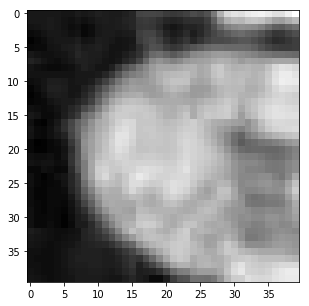

In [8]:
plt.rcParams['figure.figsize'] = (5, 5)        # large images

ind = 1
image_path = osp.join(work_root + 'shipheadtest', str(np.int_(ind))+'.jpg')

image = caffe.io.load_image(image_path)
transformed_image = transformer.preprocess('data', image)

# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

output = net.forward()
output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

# load ImageNet labels
labels_file = work_root + 'word.txt'
   
labels = np.loadtxt(labels_file, str, delimiter='\t')

print 'output label:', labels[output_prob.argmax()]
top_inds = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
img = np.array(image)
if img.ndim == 3:
    img = img[:,:,0]
plt.imshow(img)
print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

In [9]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 40, 40)
conv1	(1, 32, 40, 40)
pool1	(1, 32, 20, 20)
conv2	(1, 32, 20, 20)
pool2	(1, 32, 10, 10)
conv3	(1, 64, 10, 10)
pool3	(1, 64, 5, 5)
conv4	(1, 9, 1, 1)
reshape	(1, 9)
prob	(1, 9)


In [10]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(32, 3, 3, 3) (32,)
conv2	(32, 32, 3, 3) (32,)
conv3	(64, 32, 3, 3) (64,)
conv4	(9, 64, 5, 5) (9,)


In [11]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

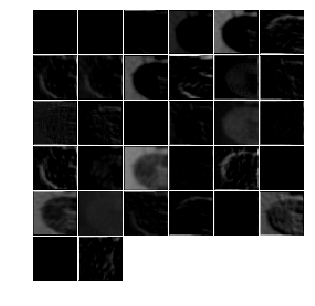

In [12]:
feat = net.blobs['conv1'].data[0]
vis_square(feat)

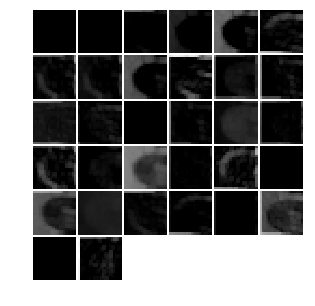

In [13]:
feat = net.blobs['pool1'].data[0]
vis_square(feat)

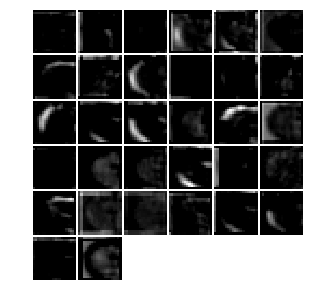

In [14]:
feat = net.blobs['conv2'].data[0]
vis_square(feat)

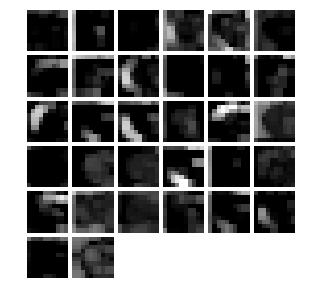

In [15]:
feat = net.blobs['pool2'].data[0]
vis_square(feat)

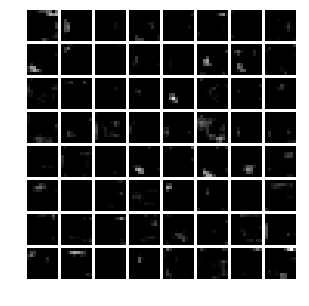

In [16]:
feat = net.blobs['conv3'].data[0]
vis_square(feat)

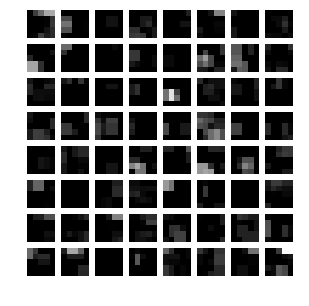

In [17]:
feat = net.blobs['pool3'].data[0]
vis_square(feat)